# Starting point: plain Tamura surface fluxes
The starting point is defined by the raw Tamura 2008 daily surface net heat and surface freshwater fluxes and daily surface stresses derived from EraInterim winds. The surface heat fluxes in summer has been reduced to half during the forcing file generation.

In [7]:
#import bunch of packages
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# add the 'src/visualization/' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)
import features.roms_ds as roms_ds


# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1
%aimport features.roms_ds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
#load and setup roms_data
ref_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','ocean_his_swfBug_0005.nc')
ref = roms_ds.make_roms_ds(ref_path)

set up multifile dataset
set up 4D mask and add as variable to dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


In [79]:
ref.ocean_time

<xarray.DataArray 'ocean_time' (ocean_time: 12)>
array(['1999-01-30T10:00:00.000000000', '1999-03-01T20:00:00.000000000',
       '1999-04-01T06:00:00.000000000', '1999-05-01T16:00:00.000000000',
       '1999-06-01T02:00:00.000000000', '1999-07-01T12:00:00.000000000',
       '1999-07-31T22:00:00.000000000', '1999-08-31T08:00:00.000000000',
       '1999-09-30T18:00:00.000000000', '1999-10-31T04:00:00.000000000',
       '1999-11-30T14:00:00.000000000', '1999-12-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 1999-01-30T10:00:00 ...

In [57]:
#load and set up initial fields for comparison
ini_path = ref_path = os.path.join('/home/ubuntu/raijin/g/data2/gh9/oxr581/waom10_data','waom10_ini.nc')
ini = xr.open_dataset(ini_path)

In [120]:
#define plotting function
def compare_trans(da,ref_da,title_str,min_val=None,max_val=None):
    
    val = da.to_masked_array()
    ref_val = ref_da.to_masked_array()
    x = da.eta_3d.fillna(0).values
    y = da.depth.fillna(0).values
    
    plt.close()
    fig,(ax1,ax2) = plt.subplots(2,figsize=(15,6))
    plt.suptitle(title_str,fontsize=16)
    
    case_plt = ax1.pcolormesh(x,y,val,vmin=min_val,vmax=max_val)
    plt.colorbar(case_plt,ax=ax1)
    ax1.set_title('Case')
    ax1.set_xlabel('latitude')
    ax1.set_ylabel('depth')
    
    ref_plt = ax2.pcolormesh(x,y,ref_val,vmin=min_val,vmax=max_val)
    plt.colorbar(ref_plt,ax=ax2)
    ax2.set_title('Reference')
    ax2.set_xlabel('latitude')
    ax2.set_ylabel('depth')
    
    plt.show()

## Temperature straification
### Colorbounds free

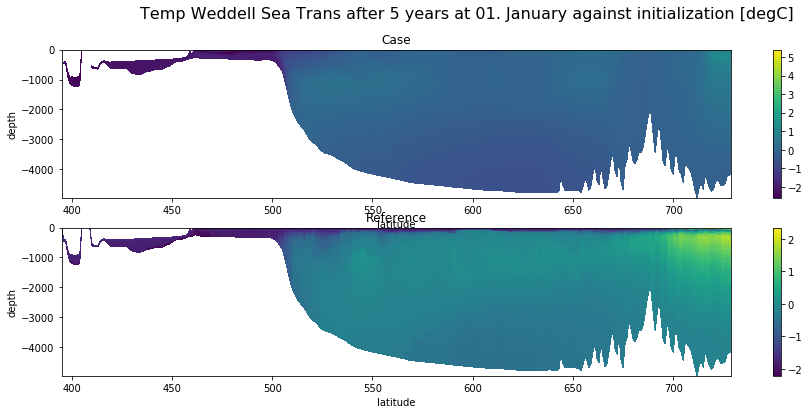

In [104]:
compare_trans(ref.temp[-1,:,395:,320],ini.temp[0,:,395:,320],'Temp Weddell Sea Trans after 5 years at 01. January against initialization [degC]')

... roms shows to high max temperatures.
### Colorbounds preset.

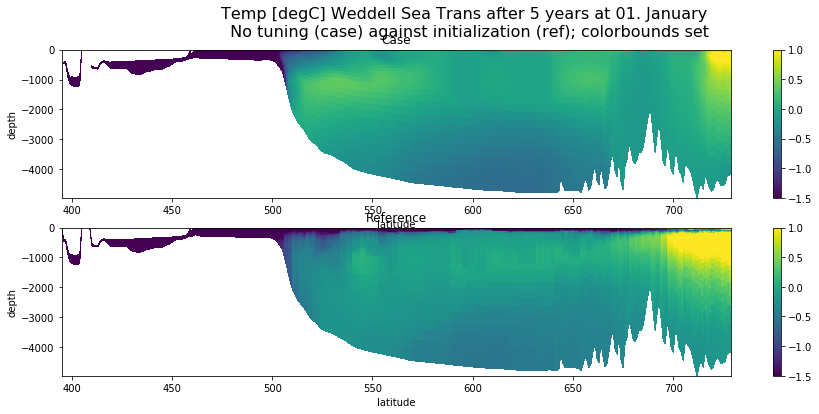

In [111]:
compare_trans(ref.temp[-1,:,395:,320],ini.temp[0,:,395:,320],
            'Temp [degC] Weddell Sea Trans after 5 years at 01. January \n No tuning (case) against initialization (ref); colorbounds set',
            -1.5,1.0)

... ROMS is to mixed.
## Salt stratification
### colobounds free

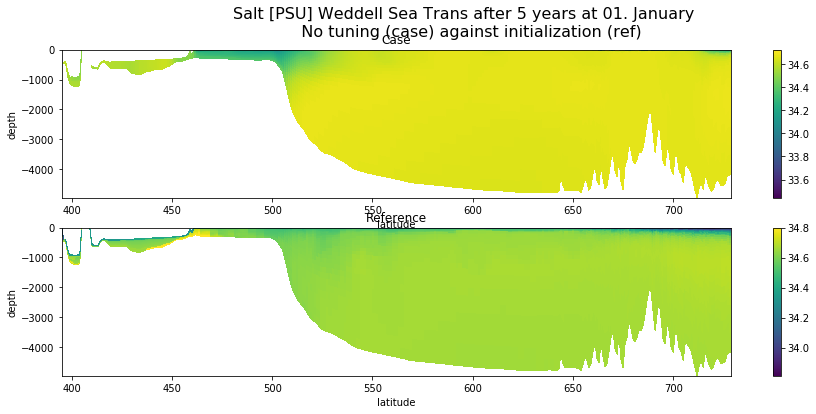

In [103]:
compare_trans(ref.salt[-1,:,395:,320],ini.salt[0,:,395:,320],
            'Salt [PSU] Weddell Sea Trans after 5 years at 01. January \n  No tuning (case) against initialization (ref)')

... roms gets to fresh.
### colobounds preset

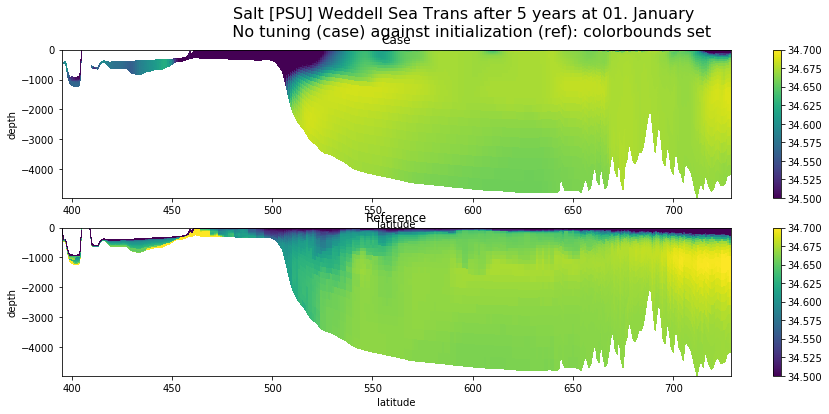

In [124]:
compare_trans(ref.salt[-1,:,395:,320],ini.salt[0,:,395:,320],
            'Salt [PSU] Weddell Sea Trans after 5 years at 01. January \n  No tuning (case) against initialization (ref): colorbounds set',
            34.5,34.7)

... roms gets to fresh on the shelf and is to mixed in the deep ocean.

# Effect of QCORRECT and freezing point restriction
The modifications are twofold.
1. if sst goes below the freezing point, surface net heat flux is relaxed towards the freezing point
2. In summer (Nov, Dec, Jan, Feb; Takeshi melt season) we relax surface net heat flux to SOSE SST with a sensitifity of -40 W/m^2/K (more or less random, order of magnitude from Barnier 1995).

In [83]:
#load and setup roms_data
QCOR_path = os.path.join(os.environ.get('rawdir'),'waom10_QCORRECT','ocean_his_0005.nc')
QCOR = roms_ds.make_roms_ds(QCOR_path)

set up multifile dataset
set up 4D mask and add as variable to dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


## Temperature stratification
### colorbounds free

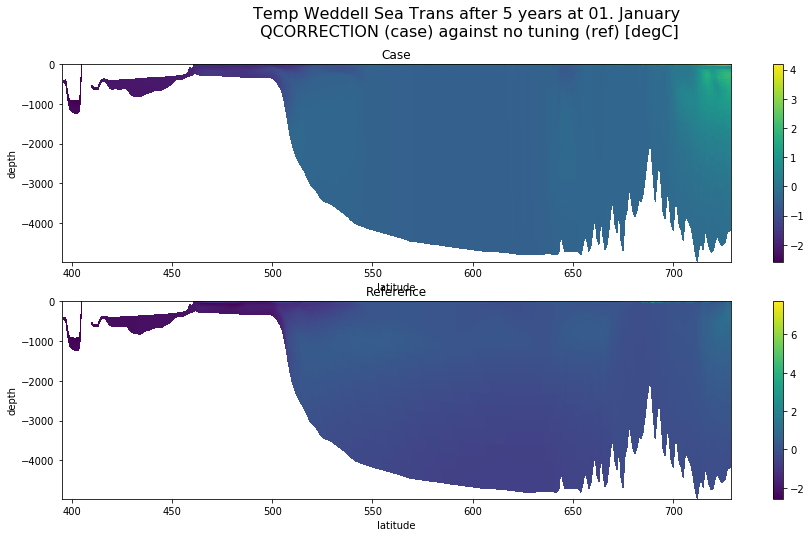

In [87]:
compare_trans(QCOR.temp[-1,:,395:,320],ref.temp[0,:,395:,320],
            'Temp Weddell Sea Trans after 5 years at 01. January\n QCORRECTION (case) against no tuning (ref) [degC]')

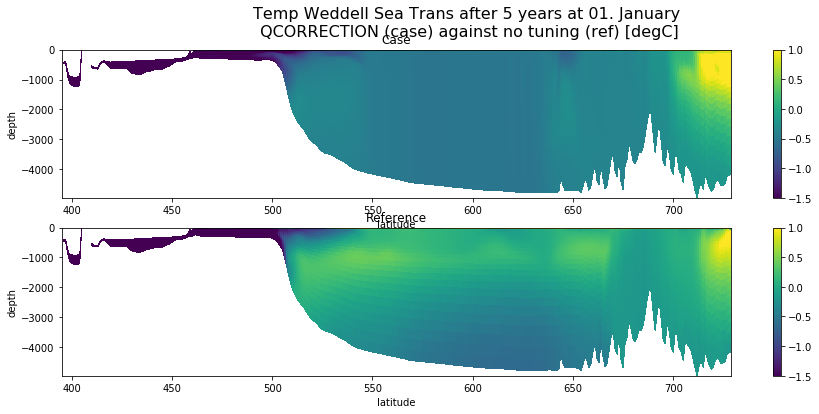

In [113]:
compare_ini(QCOR.temp[-1,:,395:,320],ref.temp[0,:,395:,320],
            'Temp Weddell Sea Trans after 5 years at 01. January\n QCORRECTION (case) against no tuning (ref) [degC]',
           -1.5,1.0)

...Max temperatures are less high, however, the ocean appears less stratified.
# Effect of deactivating tides
Simply by deactivating tides we might get a more stratified ocean due to reduced vertical mixing.

In [115]:
#load and setup roms_data
NT_path = os.path.join(os.environ.get('rawdir'),'waom10_NT','ocean_his_0005.nc')
NT = roms_ds.make_roms_ds(NT_path)

set up multifile dataset
set up 4D mask and add as variable to dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


## Temperature stratification
### colorbounds free

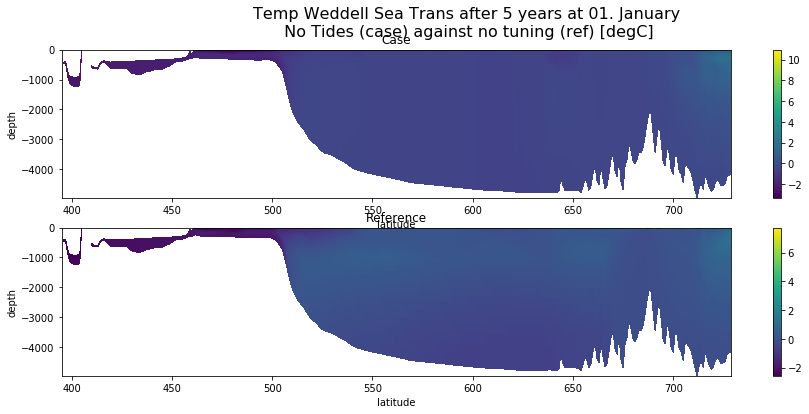

In [116]:
compare_trans(NT.temp[-1,:,395:,320],ref.temp[0,:,395:,320],
            'Temp Weddell Sea Trans after 5 years at 01. January\n No Tides (case) against no tuning (ref) [degC]')

### colorbounds preset

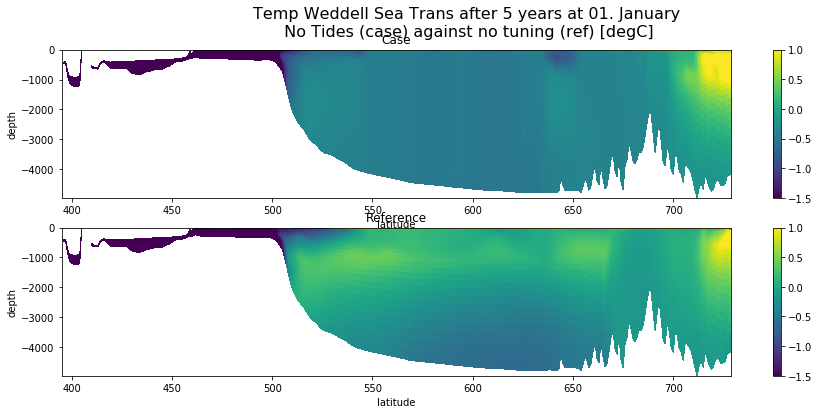

In [117]:
compare_trans(NT.temp[-1,:,395:,320],ref.temp[0,:,395:,320],
            'Temp Weddell Sea Trans after 5 years at 01. January\n No Tides (case) against no tuning (ref) [degC]',
           -1.5,1.0)

... temperature shows even higher maximal values and the ocean appears less stratified

# The effect of SCORRECTION and winter restriction
Two modifications have been applied on top of the heat flux correction:
1. Sea surface salt flux gets relaxed to SSS from SOSE. The relaxation time scale is 30 days and the the nudging happens all year round.
2. Salt flux is set to zero if the ocean loses heat (winter), but is not close to the freezing point. This was implemented to avoid salt input in warm water (Takeshi says its a polynya, but roms is not yet at freezing point). CAUTION, this will most likey mess up Takeshis annual salt balance. Maybe the ocean is freshening in longer integrations now, however maybe SOSE flux correction will balance this.  

In [119]:
#load and setup roms_data
SCOR_path = os.path.join(os.environ.get('rawdir'),'waom10_SCORRECT','ocean_his_lowNudge_swfBug_0005.nc')
SCOR = roms_ds.make_roms_ds(SCOR_path)

set up multifile dataset
set up 4D mask and add as variable to dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


## Salinity stratification
### colorbounds free

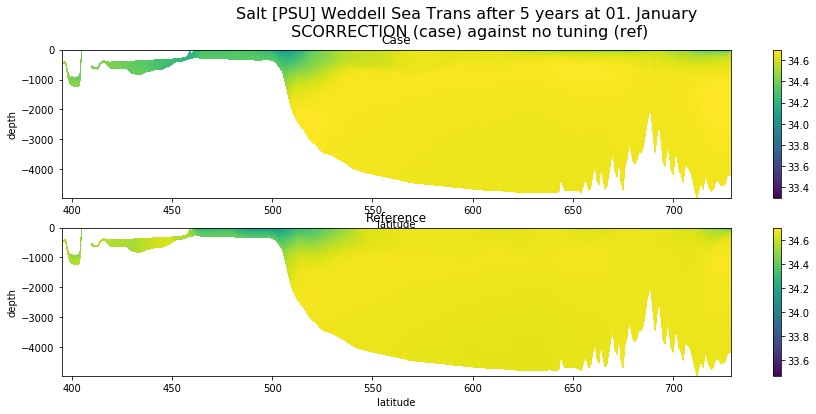

In [121]:
compare_trans(SCOR.salt[-1,:,395:,320],ref.salt[0,:,395:,320],
            'Salt [PSU] Weddell Sea Trans after 5 years at 01. January\n SCORRECTION (case) against no tuning (ref)')

### colorbounds preset

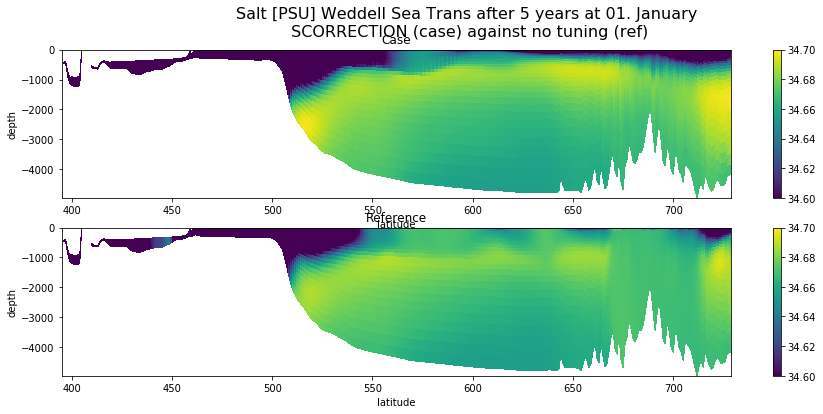

In [125]:
compare_trans(SCOR.salt[-1,:,395:,320],ref.salt[0,:,395:,320],
            'Salt [PSU] Weddell Sea Trans after 5 years at 01. January\n SCORRECTION (case) against no tuning (ref)',
             34.6,34.7)

... roms seems to be more stratified in the inerior, However the ice shelf cavity is even fresher than before.

... does not work! Salinity restoring all year round seems to be important.
# Evaluation of best case (salt all year, heat in summer)
## Stratification in deep ocean: annual mean salt and temperature fields along longitiude transsects compared against SOSE

In [2]:
# Generate ROMS and SOSE Xarray datasets
import xarray as xr
import os
import sys
import numpy as np

src_path = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_path)
# import my functions
import features.roms_ds as roms_ds

import features.sose_ds as sose_ds


In [3]:
#load roms_data
roms_data_path = os.path.join(os.environ.get('rawdir'),'waom10_SCORRECT','ocean_avg_lowNudge_swfBug_0004.nc')
rds = roms_ds.make_roms_ds(roms_data_path)

set up multifile dataset
set up 4D mask and add as variable to dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


In [9]:
#load sose_data
sds = sose_ds.make_TS_ds(records=np.arange(0,12))

load grid
load temperature


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


load salt
construct Xarray dataset
done!


In [ ]:
#define function that generates a sose vs roms longitude transsect as monthly widget or annual meandefine function that generates a sose vs roms longitude transsect as monthly widget or annual mean
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as ocm

def plot_lont(sds,rds,lon,lats,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8,mean=True):
    
    if lon < 0.0:
        slon = lon + 360.0
        rlon = lon
    elif lon > 180:
        slon = lon
        rlon = lon - 360.0
    else:
        slon = lon
        rlon = lon
        
    print('lookup nearest neighbors from roms')
    rtemp_flat = rds.temp.stack(xieta=('xi_rho','eta_rho'))
    rsalt_flat = rds.salt.stack(xieta=('xi_rho','eta_rho')) 
    points = np.column_stack((rtemp_flat.lat_rho.values,rtemp_flat.lon_rho.values))
    tree = KDTree(points)
    
    lats_t = sds.sel(longitude=slon,latitude=lats,method='nearest').latitude.values
    lons_t = np.full(np.shape(lats_t),rlon,dtype=int)
    target = np.column_stack((lats_t,lons_t))
    dist, ind = tree.query(target)
    
    print('define axes and values from roms')
    rtemp_tr = rtemp_flat[:,:,ind]
    rsalt_tr = rsalt_flat[:,:,ind]
    x=rtemp_tr[0].lat_rho.to_masked_array()
    y=rtemp_tr[0].depth.to_masked_array()
    rtemp_val=rtemp_tr.to_masked_array()
    rsalt_val=rsalt_tr.to_masked_array()
    
    print('generate widget including sose plotting')
    plt.close()
    
    if mean==False:
        def plot(month):
            fig,axes = plt.subplots(2,2,figsize=(15,12))
            (ax1,ax2,ax3,ax4) = axes.flatten()

            sds.temperature.sel(longitude=slon,latitude=lats,method='nearest')[month].plot(ax=ax1,x='latitude',y='depth',vmin=tmin,vmax=tmax,cmap=ocm.thermal)
            ax1.set_title('SOSE')
            sds.salinity.sel(longitude=slon,latitude=lats,method='nearest')[month].plot(ax=ax3,x='latitude',y='depth',vmin=smin,vmax=smax,cmap=ocm.haline)
            ax3.set_title('SOSE')

            temp_plt = ax2.pcolormesh(x,y,rtemp_val[month],vmin=tmin,vmax=tmax,cmap=ocm.thermal)
            plt.colorbar(temp_plt,ax=ax2,label='temperature')
            ax2.set_title('ROMS')
            ax2.set_xlabel('latitude')
            ax2.set_ylabel('depth')

            salt_plt = ax4.pcolormesh(x,y,rsalt_val[month],vmin=smin,vmax=smax,cmap=ocm.haline)
            plt.colorbar(salt_plt,ax=ax4,label='salinity')
            ax4.set_title('ROMS')
            ax4.set_xlabel('latitude')
            ax4.set_ylabel('depth')

            if max_depth != None:
                for ax in [ax1,ax2,ax3,ax4]:
                    ax.set_ylim([-max_depth,0])

            plt.show()

        interact(plot,month=(0,11))
        
    elif mean == True:
        
        fig,axes = plt.subplots(2,2,figsize=(15,12))
        (ax1,ax2,ax3,ax4) = axes.flatten()

        sds.temperature.sel(longitude=slon,latitude=lats,method='nearest').mean('time').plot(ax=ax1,x='latitude',y='depth',vmin=tmin,vmax=tmax)
        ax1.set_title('SOSE')
        sds.salinity.sel(longitude=slon,latitude=lats,method='nearest').mean('time').plot(ax=ax3,x='latitude',y='depth',vmin=smin,vmax=smax)
        ax3.set_title('SOSE')

        temp_plt = ax2.pcolormesh(x,y,np.mean(rtemp_val,axis=0),vmin=tmin,vmax=tmax)
        plt.colorbar(temp_plt,ax=ax2,label='temperature')
        ax2.set_title('ROMS')
        ax2.set_xlabel('latitude')
        ax2.set_ylabel('depth')

        salt_plt = ax4.pcolormesh(x,y,np.mean(rsalt_val,axis=0),vmin=smin,vmax=smax)
        plt.colorbar(salt_plt,ax=ax4,label='salinity')
        ax4.set_title('ROMS')
        ax4.set_xlabel('latitude')
        ax4.set_ylabel('depth')
        
        if max_depth != None:
            for ax in [ax1,ax2,ax3,ax4]:
                ax.set_ylim([-max_depth,0])

        plt.show()

### Weddell sea at longitude 45 deg W

lookup nearest neighbors from roms
define axes and values from roms
generate widget including sose plotting


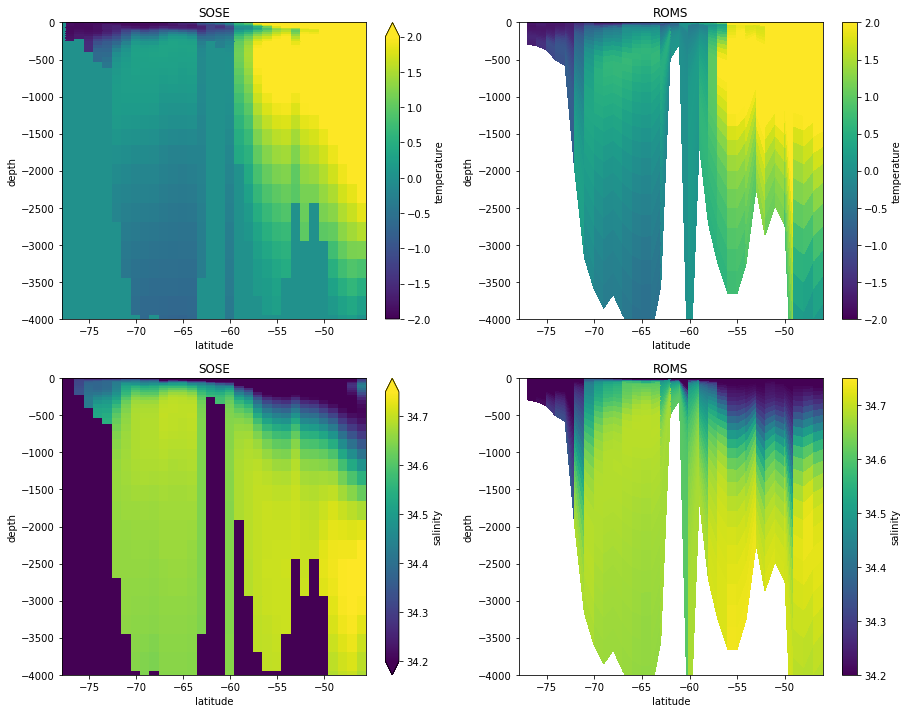

In [689]:
plot_lont(sds,rds,-45,np.arange(-80,-45),tmin=-2,tmax=2,smin=34.2,smax=34.75,max_depth=4000)

### Ross sea at longitude 180

lookup nearest neighbors from roms
define axes and values from roms
generate widget including sose plotting


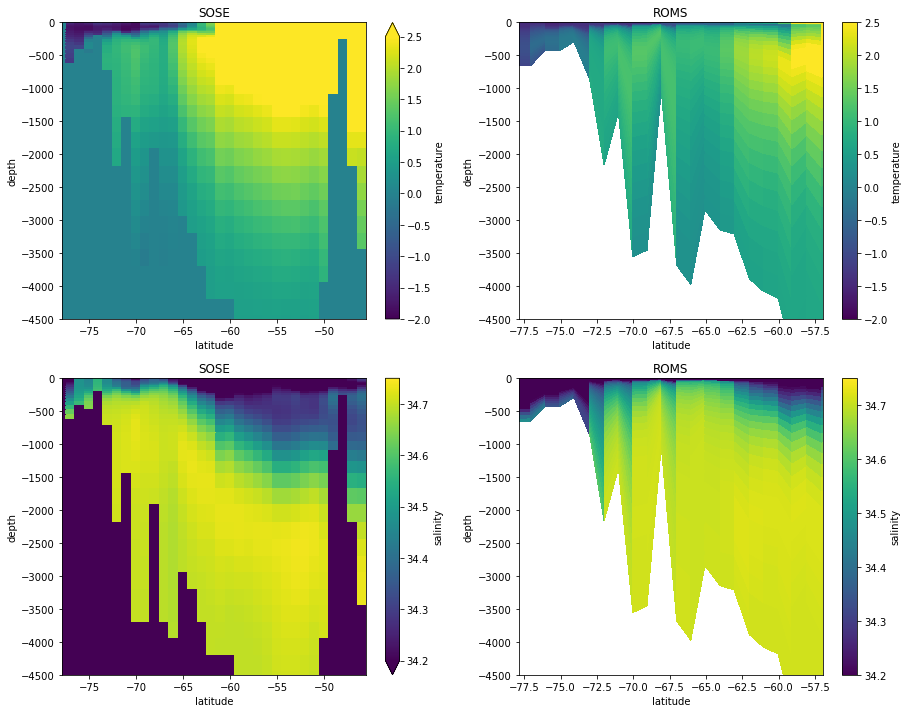

In [533]:
plot_lont(sds,rds,180,np.arange(-89,-45),tmin=-2,tmax=2.5,smin=34.2,smax=34.75,max_depth=4500)

### Bellinghausen Sea and Drake Passage at longitude 75 W

lookup nearest neighbors from roms
define axes and values from roms
generate widget including sose plotting


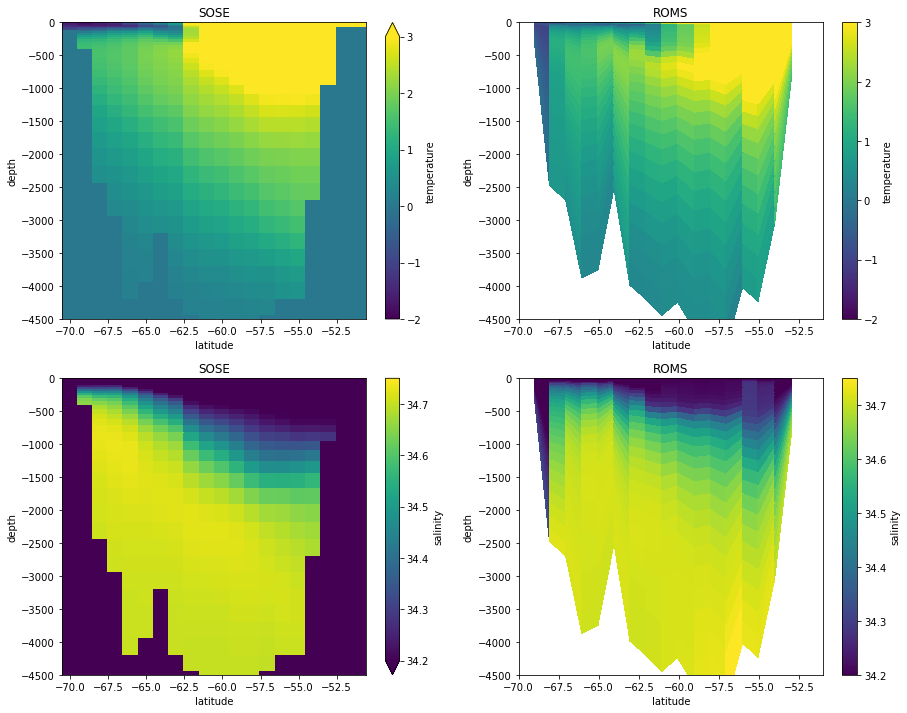

In [536]:
plot_lont(sds,rds,-75,np.arange(-70,-50),tmin=-2,tmax=3,smin=34.2,smax=34.75,max_depth=4500)

### Davis sea longitude 70 deg E

lookup nearest neighbors from roms
define axes and values from roms
generate widget including sose plotting


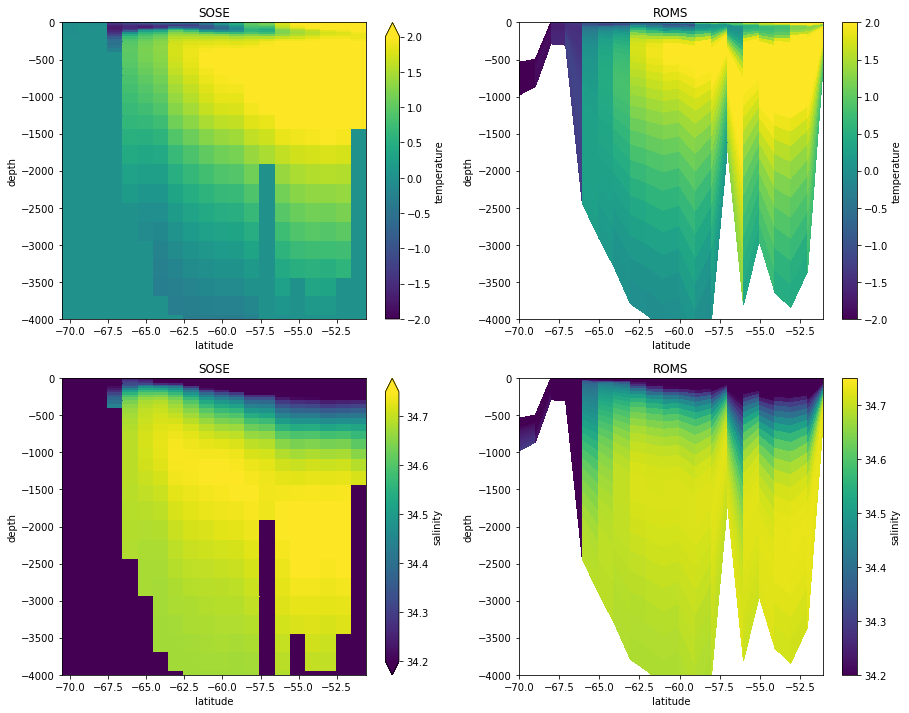

In [534]:
plot_lont(sds,rds,70,np.arange(-70,-50),tmin=-2,tmax=2,smin=34.2,smax=34.75,max_depth=4000)

## On shelf stratification: Annual averges compared against SOSE
### Defining the transsects and plotting function

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


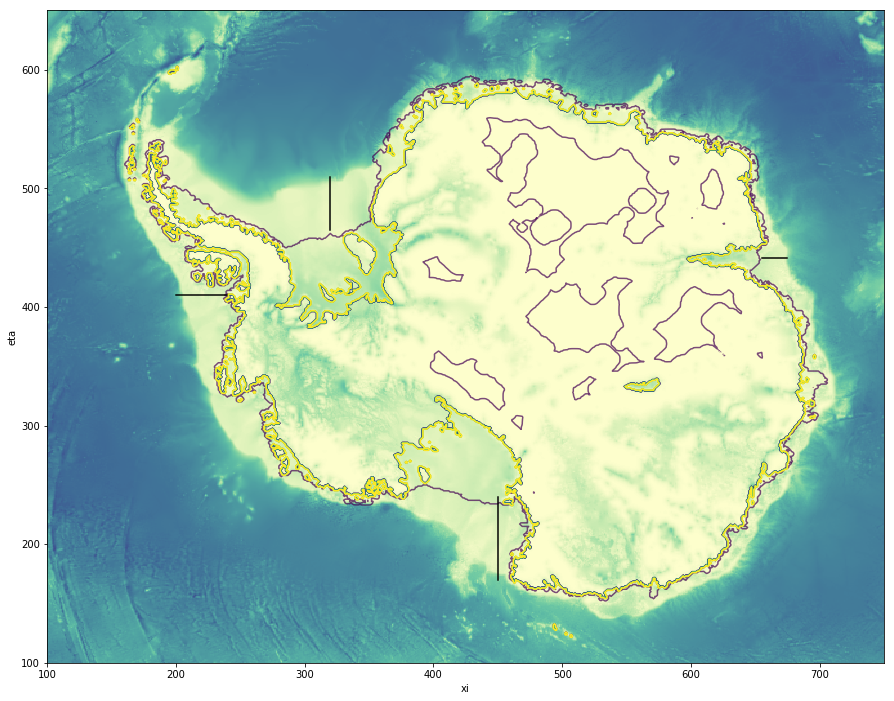

In [8]:
import cmocean.cm as cmo
import matplotlib.pyplot as plt

plt.close()
fig = plt.figure(figsize=(15,12))
plt.pcolormesh(rds.h,cmap=cmo.deep)
plt.contour(rds.zice,[-0.01],alpha=0.7)
plt.contour(rds.mask_rho)
plt.xlabel('xi')
plt.ylabel('eta')
#linescodeline = [xi_min,eta_min,xi_max,eta_max]
davis=[655,441,675,441,"amery"]
ross=[450,170,450,240,"ross"]
weddell=[320,465,320,510,"weddel"]
amundsen=[200,410,240,410,"bellinghausen"]

for line in [davis,ross,weddell,amundsen]:
    plt.plot((line[0],line[2]),(line[1],line[3]),"k-")

plt.xlim((100,750))
plt.ylim((100,650))
plt.show()

In [16]:
def compare_onshore(rds,sds,grid_coord,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8):            

    print('define slice')
    [xi_min,eta_min,xi_max,eta_max,loc] = grid_coord

    

    rds_tr = rds.isel(eta_rho=slice(eta_min,eta_max+1),xi_rho=slice(xi_min,xi_max+1))

    x = rds_tr.lat_rho.values.squeeze()
    y = rds_tr.depth[0].values.squeeze()
    
    lons = rds_tr.lon_rho.to_masked_array().squeeze()
    lons[lons<0]+=360.0
    lats = rds_tr.lat_rho.to_masked_array().squeeze()
    
    lon_da = xr.DataArray(lons,dims='latitude')
    lat_da = xr.DataArray(lats,dims='latitude')
    
    print('calculate mean')
    temp_val = rds_tr.temp.mean('ocean_time').to_masked_array().squeeze()
    salt_val = rds_tr.salt.mean('ocean_time').to_masked_array().squeeze()
    
    print('plot')
    plt.close()
    
    fig,axes = plt.subplots(2,2,figsize=(15,10))
    (ax1,ax2,ax3,ax4) = axes.flatten()
    
    temp_plt = ax1.pcolormesh(x,y,temp_val,vmin=tmin,vmax=tmax,cmap=cmo.thermal)
    plt.colorbar(temp_plt,ax=ax1,label='Temperature in deg C')
    ax1.set_title('ROMS')
    ax1.set_xlabel('latitude')
    ax1.set_ylabel('depth')

    sds.temperature.sel(longitude=lon_da,latitude=lat_da,method='nearest').mean('time').plot(ax=ax2,vmin=tmin,vmax=tmax,cmap=cmo.thermal)
    ax2.set_title('SOSE')

    salt_plt = ax3.pcolormesh(x,y,salt_val,vmin=smin,vmax=smax,cmap =cmo.haline)
    plt.colorbar(salt_plt,ax=ax3,label='Salinity in PSU')
    ax3.set_title('ROMS')
    ax3.set_xlabel('latitude')
    ax3.set_ylabel('depth')

    sds.salinity.sel(longitude=lon_da,latitude=lat_da,method='nearest').mean('time').plot(ax=ax4,vmin=smin,vmax=smax,cmap=cmo.haline)
    ax4.set_title('SOSE')

    if max_depth != None:
        for ax in [ax1,ax2,ax3,ax4]:
            ax.set_ylim([-max_depth,0])
    
    plt.show()        

### Davis sea

define slice
calculate mean
plot


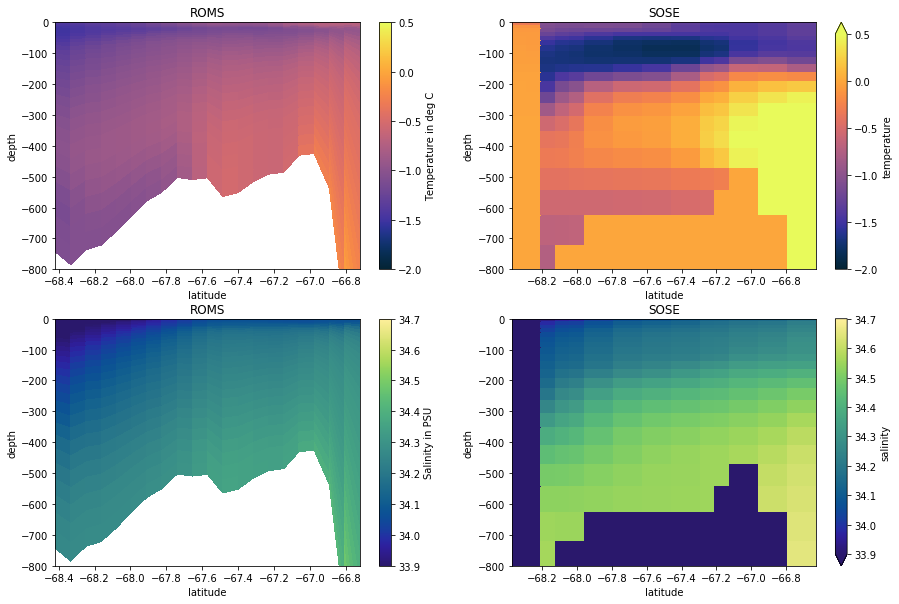

In [18]:
compare_onshore(rds,sds,davis,tmin=-2.0,tmax=0.5,smin=33.9,smax=34.7,max_depth=800)

### Weddell sea

define slice
calculate mean
plot


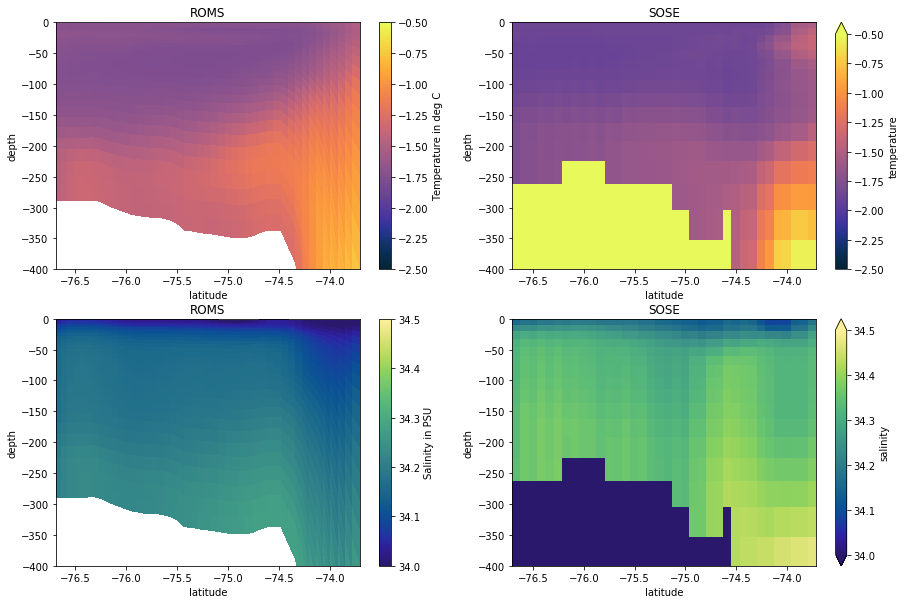

In [19]:
compare_onshore(rds,sds,weddell,tmin=-2.5,tmax=-0.5,smin=34.0,smax=34.5,max_depth=400)

### Amundsen sea

define slice
calculate mean
plot


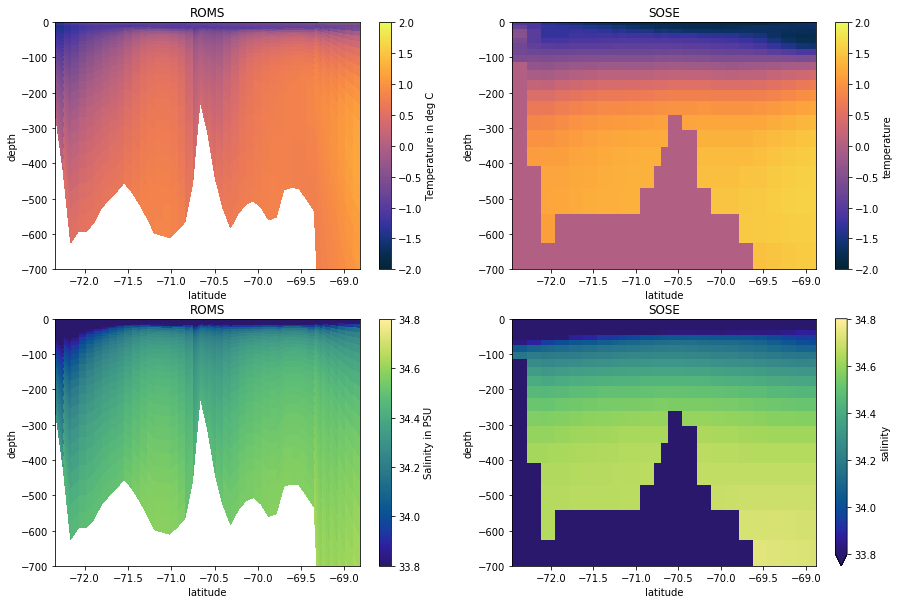

In [23]:
compare_onshore(rds,sds,amundsen,tmin=-2.0,tmax=2.0,smin=33.8,smax=34.8,max_depth=700)

### Ross sea

define slice
calculate mean
plot


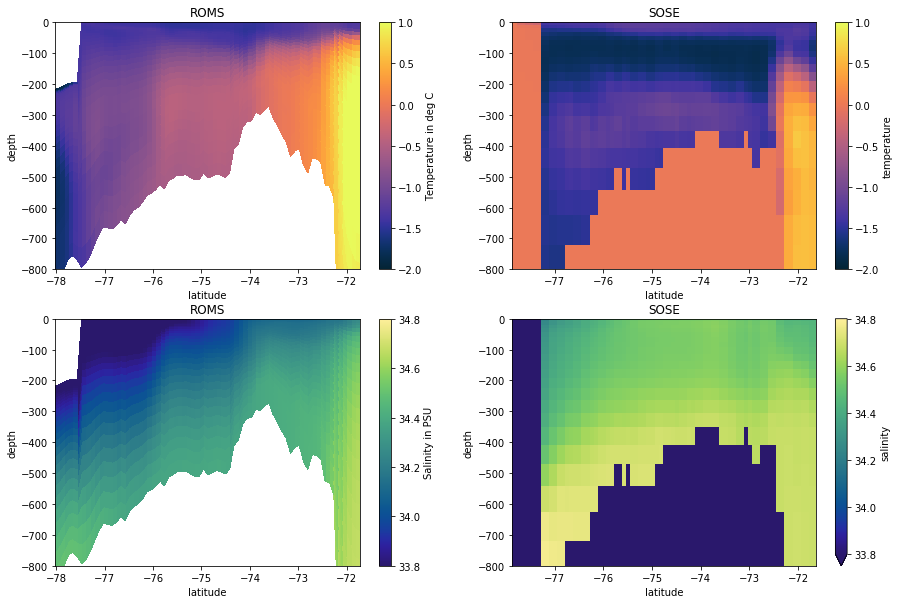

In [22]:
compare_onshore(rds,sds,ross,tmin=-2.0,tmax=1.0,smin=33.8,smax=34.8,max_depth=800)

## Under Ice shelf stratification: Monthly averages ROMS alone
### Defining transsects and plotting function 

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


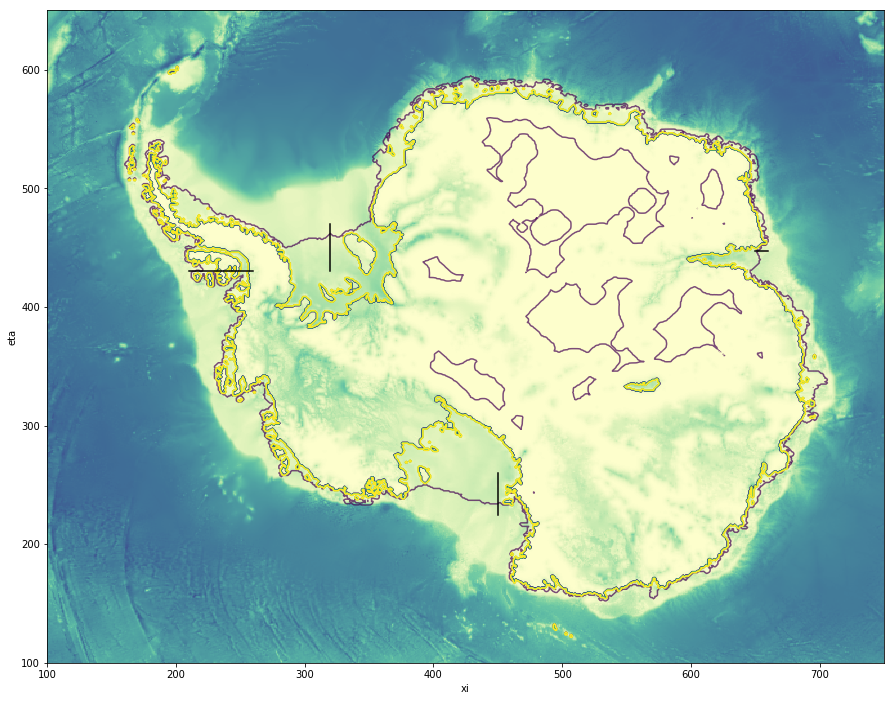

In [7]:
import cmocean.cm as cmo
import matplotlib.pyplot as plt

plt.close()
fig = plt.figure(figsize=(15,12))
plt.pcolormesh(rds.h,cmap=cmo.deep)
plt.contour(rds.zice,[-0.01],alpha=0.7)
plt.contour(rds.mask_rho)
plt.xlabel('xi')
plt.ylabel('eta')
#linescodeline = [xi_min,eta_min,xi_max,eta_max]
amery=[650,447,660,447,"amery"]
ross=[450,225,450,260,"ross"]
weddell=[320,430,320,470,"weddel"]
bellinghausen=[210,430,260,430,"bellinghausen"]

for line in [amery,ross,weddell,bellinghausen]:
    plt.plot((line[0],line[2]),(line[1],line[3]),"k-")

plt.xlim((100,750))
plt.ylim((100,650))
plt.show()

In [5]:
from ipywidgets import interact

def plot_cavity(rds,grid_coord,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8,mean=True):            

    print('define slice')
    [xi_min,eta_min,xi_max,eta_max,loc] = grid_coord

    plt.close()

    rds_tr = rds.isel(eta_rho=slice(eta_min,eta_max+1),xi_rho=slice(xi_min,xi_max+1))
    
    x = rds_tr.lat_rho.values.squeeze()
    y = rds_tr.depth[0].values.squeeze()
    
    y[np.isnan(y)]=0.0
    
    if mean == True:
        
        fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(15,10))
        
        print('calculate mean')
        temp_val = rds_tr.temp.mean('ocean_time').to_masked_array().squeeze()
        salt_val = rds_tr.salt.mean('ocean_time').to_masked_array().squeeze()

        print('plot')
        temp_plt = ax1.pcolormesh(x,y,temp_val,vmin=tmin,vmax=tmax,cmap=cmo.thermal)
        plt.colorbar(temp_plt,ax=ax1,label='deg C')
        ax1.set_title('Temperature')
        ax1.set_ylabel('depth')

        salt_plt = ax2.pcolormesh(x,y,salt_val,vmin=smin,vmax=smax,cmap =cmo.haline)
        plt.colorbar(salt_plt,ax=ax2,label='PSU')
        ax2.set_title('Salinity')
        ax2.set_xlabel('latitude')
        ax2.set_ylabel('depth')

        if max_depth != None:
            for ax in [ax1,ax2]:
                ax.set_ylim([-max_depth,0])
        
        plt.show()
        
    elif mean == False:
        
        print('set up widget')
        def widget(month):
            
            fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(15,10))

            temp_val = rds_tr.temp.to_masked_array().squeeze()
            salt_val = rds_tr.salt.to_masked_array().squeeze()

            temp_plt = ax1.pcolormesh(x,y,temp_val[month],vmin=tmin,vmax=tmax,cmap=cmo.thermal)
            plt.colorbar(temp_plt,ax=ax1,label='deg C')
            ax1.set_title('Temperature')
            ax1.set_ylabel('depth')

            salt_plt = ax2.pcolormesh(x,y,salt_val[month],vmin=smin,vmax=smax,cmap =cmo.haline)
            plt.colorbar(salt_plt,ax=ax2,label='PSU')
            ax2.set_title('Salinity')
            ax2.set_xlabel('latitude')
            ax2.set_ylabel('depth')
            
            if max_depth != None:
                for ax in [ax1,ax2]:
                    ax.set_ylim([-max_depth,0])
            
            plt.show()
            
        interact(widget,month=(0,11))

### Amery ice shelf cavity

In [6]:
plot_cavity(rds,amery,tmin=-2.5,tmax=-1.0,smin=33.9,smax=34.35,mean=False,max_depth=1000)

NameError: name 'amery' is not defined

### Ronne Flichner cavity

In [30]:
plot_cavity(rds,weddell,tmin=-2.25,tmax=-1.5,smin=34,smax=34.3,mean=False,max_depth=800)

define slice
set up widget


interactive(children=(IntSlider(value=5, description='month', max=11), Output()), _dom_classes=('widget-interact',))

### Ross ice shelf cavity and sea

In [27]:
plot_cavity(rds,ross,tmin=-2.0,tmax=-1.0,smin=33.7,smax=34.5,mean=False,max_depth=900)

define slice
set up widget


interactive(children=(IntSlider(value=5, description='month', max=11), Output()), _dom_classes=('widget-interact',))

### Bellinghausen ice shelves and sea

In [28]:
plot_cavity(rds,bellinghausen,tmin=-1.5,tmax=0.5,smin=33.7,smax=34.5,mean=False,max_depth=800)

define slice
set up widget


interactive(children=(IntSlider(value=5, description='month', max=11), Output()), _dom_classes=('widget-interact',))

... has the takeshi salt flux the wrong sign???? When sea ice is supposed to grow Mar(2)-Oct(9) lots of freshwater instead of salt get dumped into the ocean... lets check with a case before scorrection.
### Amery ice shelf front to see Polynya deep convection

In [16]:
plot_cavity(rds,amery,tmin=-2.0,tmax=-1.5,smin=34.1,smax=34.4,mean=False,max_depth=800)

define slice
set up widget


interactive(children=(IntSlider(value=5, description='month', max=11), Output()), _dom_classes=('widget-interact',))